In [1]:
import pandas as pd
import numpy as np

import os
import random

from numpy.random import seed

from keras.layers.experimental import preprocessing
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# For reproducible results
seed_value = 1
os.environ['PYTHONHASHSEED'] = str(seed_value)

random.seed(seed_value)

np.random.seed(seed_value)

tf.random.set_seed(seed_value)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [3]:
OUTPUT_PATH = './Data/output/'

### Import dataset

In [4]:
dataset_raw = pd.read_csv(OUTPUT_PATH + 'CleanData_Population_Schools_SDGs.csv')
dataset = dataset_raw.dropna()
dataset.head()

,PSGC_BRGY,both_age_0_to_4,male_age_0_to_4,female_age_0_to_4,both_age_5_to_9,male_age_5_to_9,female_age_5_to_9,both_age_10_to_14,male_age_10_to_14,female_age_10_to_14,...,SDG_Type_Worker_Pro,SDG_Type_Worker_Tec,SDG_Type_Worker_Cle,SDG_Type_Worker_Ser,SDG_Type_Worker_Ski,SDG_Type_Worker_Cra,SDG_Type_Worker_Pla,SDG_Type_Worker_Ele,SDG_Type_Worker_Arm,SDG_less_than_54_sqft
0,PH150702001,88.0,54.0,34.0,79.0,35.0,44.0,73.0,42.0,31.0,...,0.042654,0.014218,0.085308,0.208531,0.507109,0.033175,0.014218,0.052133,0.023697,0.275449
1,PH150702002,210.0,100.0,110.0,161.0,77.0,84.0,133.0,69.0,64.0,...,0.047619,0.002976,0.011905,0.047619,0.529762,0.053571,0.119048,0.113095,0.000000,0.287554
3,PH150702005,277.0,152.0,125.0,305.0,159.0,146.0,269.0,155.0,114.0,...,0.051637,0.021411,0.040302,0.070529,0.488665,0.032746,0.059194,0.164987,0.011335,0.002092
4,PH150702006,352.0,146.0,206.0,354.0,201.0,153.0,398.0,217.0,181.0,...,0.016966,0.002994,0.023952,0.106786,0.525948,0.019960,0.048902,0.171657,0.004990,0.061657
5,PH150702007,270.0,140.0,130.0,236.0,114.0,122.0,220.0,121.0,99.0,...,0.026316,0.011696,0.023392,0.084795,0.494152,0.081871,0.125731,0.096491,0.010234,0.391509


### Preprocess data

In [5]:
SDG = dataset.iloc[:,84:]
SDG['PSGC_BRGY'] = dataset['PSGC_BRGY']

#### 1. Elementary

In [6]:
data_elem = SDG.copy()
data_elem['NUM_SCHOOLS'] = dataset['SCH_CAT_CES'] + dataset['SCH_CAT_ES'] + dataset['SCH_CAT_PS'] + dataset['SCH_CAT_PES']
data_elem['ELEM_POPN'] = dataset['both_age_6_to_12']
len(data_elem)

1529

In [7]:
zero_schools_elem = data_elem[data_elem['NUM_SCHOOLS'] == 0]
data_elem = data_elem[data_elem['NUM_SCHOOLS'] != 0]
data_elem = data_elem.drop(['PSGC_BRGY'], axis=1)
len(data_elem)

1488

#### 2. High School

In [8]:
data_hs = SDG.copy()
data_hs['NUM_SCHOOLS'] = dataset['SCH_CAT_JHS'] + dataset['SCH_CAT_SHS'] + dataset['SCH_CAT_PJHS'] + dataset['SCH_CAT_PSHS']
data_hs['HS_POPN'] = dataset['both_age_13_to_16']
len(data_hs)

1529

In [9]:
zero_schools_hs = data_hs[data_hs['NUM_SCHOOLS'] == 0]
data_hs = data_hs[data_hs['NUM_SCHOOLS'] != 0]
data_hs = data_hs.drop(['PSGC_BRGY'], axis=1)
len(data_hs)

320

#### 3. Merged Elem and High School
For feature selection

In [11]:
data_merged = pd.read_csv(OUTPUT_PATH + 'CleanData_clustering.csv')
data_merged = data_merged.dropna()

### Modelling

In [33]:
training_data, testing_data = train_test_split(data_hs, test_size=0.2, random_state=42)

In [34]:
X_train = training_data.drop(['NUM_SCHOOLS'], axis=1)
y_train = training_data['NUM_SCHOOLS']

X_test = testing_data.drop(['NUM_SCHOOLS'], axis=1)
y_test = testing_data['NUM_SCHOOLS']

In [35]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X_train))

In [36]:
def base_model():
    np.random.seed(1)
    model = Sequential()
    model.add(normalizer)
    model.add(Dense(4, input_dim=2, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam')
#     model.add(Dense(20, activation='tanh', input_dim=5, kernel_initializer='uniform'))
#     model.add(Dense(1, activation='linear', kernel_initializer='uniform'))
    
    model.compile(loss='mse', optimizer='adam')
    return model

In [37]:
model = base_model()
EPOCHS = 200
BATCH_SIZE = 10


callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history = model.fit(X_train, 
                    y_train, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE,
                    validation_split=0.2,
                    callbacks=callback)

Epoch 1/200
21/21 [==============================] - 1s 8ms/step - loss: 1.6785 - val_loss: 0.9036
Epoch 2/200
21/21 [==============================] - 0s 2ms/step - loss: 1.4243 - val_loss: 0.7896
Epoch 3/200
21/21 [==============================] - 0s 2ms/step - loss: 1.2117 - val_loss: 0.6848
Epoch 4/200
21/21 [==============================] - 0s 2ms/step - loss: 1.1483 - val_loss: 0.5866
Epoch 5/200
21/21 [==============================] - 0s 2ms/step - loss: 0.7889 - val_loss: 0.4813
Epoch 6/200
21/21 [==============================] - 0s 2ms/step - loss: 0.7096 - val_loss: 0.3860
Epoch 7/200
21/21 [==============================] - 0s 2ms/step - loss: 0.5439 - val_loss: 0.3263
Epoch 8/200
21/21 [==============================] - 0s 2ms/step - loss: 0.4693 - val_loss: 0.2896
Epoch 9/200
21/21 [==============================] - 0s 2ms/step - loss: 0.5076 - val_loss: 0.2725
Epoch 10/200
21/21 [==============================] - 0s 2ms/step - loss: 0.4933 - val_loss: 0.2586
Epoch 11/

21/21 [==============================] - 0s 2ms/step - loss: 0.2432 - val_loss: 0.1110
Epoch 84/200
21/21 [==============================] - 0s 2ms/step - loss: 0.2139 - val_loss: 0.1064
Epoch 85/200
21/21 [==============================] - 0s 2ms/step - loss: 0.2281 - val_loss: 0.1144
Epoch 86/200
21/21 [==============================] - 0s 2ms/step - loss: 0.2340 - val_loss: 0.1148
Epoch 87/200
21/21 [==============================] - 0s 2ms/step - loss: 0.2886 - val_loss: 0.1145
Epoch 88/200
21/21 [==============================] - 0s 2ms/step - loss: 0.3185 - val_loss: 0.1092
Epoch 89/200
21/21 [==============================] - 0s 2ms/step - loss: 0.2239 - val_loss: 0.1081
Epoch 90/200
21/21 [==============================] - 0s 2ms/step - loss: 0.1468 - val_loss: 0.1152
Epoch 91/200
21/21 [==============================] - 0s 2ms/step - loss: 0.1603 - val_loss: 0.1147
Epoch 92/200
21/21 [==============================] - 0s 3ms/step - loss: 0.3318 - val_loss: 0.1162
Epoch 93/200


In [38]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
131,0.187510,0.127156,131
132,0.185760,0.123160,132
133,0.185880,0.125217,133
134,0.186538,0.119541,134
135,0.186734,0.133793,135


In [39]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

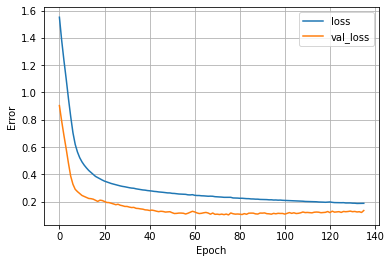

In [40]:
plot_loss(history)

In [41]:
y_pred = model.predict(X_test)

In [42]:
y_pred_round = np.round(y_pred)

In [43]:
accuracy_score(y_test, y_pred_round)

0.78125

In [44]:
# model.save(OUTPUT_PATH + 'Model_NN_HS')

### PREDICT BRGY WITHOUT SCHOOL

In [45]:
def predict(X_predict):
    y_pred_null = model.predict(X_predict)
    X_predict['Pred_school_num'] = np.round(y_pred_null)
    X_predict['PSGC_BRGY'] = dataset_null['PSGC_BRGY']
    return X_predict

In [46]:
dataset_null = dataset_raw[dataset_raw.isnull().any(axis=1)]
len(dataset_null)

953

In [47]:
X_predict = dataset_null.iloc[:,84:]
X_predict['HS_POPN'] = dataset_null['both_age_13_to_16']

In [48]:
pred_1 = predict(X_predict)
pred_1['PSGC_BRGY'] = dataset_null['PSGC_BRGY']

In [49]:
zero_schools = zero_schools_hs.drop(['NUM_SCHOOLS','PSGC_BRGY'], axis=1)

In [50]:
pred_2 = predict(zero_schools)
pred_2['PSGC_BRGY'] = zero_schools_hs['PSGC_BRGY']

In [51]:
predicted_df = pd.concat([pred_1, pred_2])

In [52]:
len(predicted_df)

2162

In [53]:
predicted_df.to_csv(OUTPUT_PATH + 'Model_NN_Output_HS.csv', index=False)

### FEATURE IMPORTANCE

In [44]:
from sklearn.model_selection import cross_val_score, KFold
from keras.wrappers.scikit_learn import KerasRegressor

import eli5
from eli5.sklearn import PermutationImportance

In [45]:
estimator = KerasRegressor(build_fn=base_model, nb_epoch=EPOCHS, 
                    batch_size=BATCH_SIZE,
                    validation_split=0.2)
kfold = KFold(n_splits=10, random_state=1, shuffle=True)

In [46]:
results = cross_val_score(estimator, X_train, y_train, cv=kfold)

12/12 [==============================] - 0s 816us/step - loss: 1.4270


In [47]:
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Results: -1.81 (0.65) MSE


In [48]:
estimator.fit(X_train, y_train)

96/96 [==============================] - 0s 2ms/step - loss: 5.1113 - val_loss: 4.3918


In [49]:
perm = PermutationImportance(estimator, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

119/119 [==============================] - 0s 999us/step - loss: 3.6782


Weight,Feature
0.1131 ± 0.0511,SDG_Type_Building_Single_Pct
0.0831 ± 0.0330,SDG_Type_Worker_Cle
0.0808 ± 0.0250,SDG_Type_Worker_Pla
0.0632 ± 0.0323,SDG_Households_Drinking_Owned_Faucet_Pct
0.0593 ± 0.0156,SDG_Type_Worker_Tec
0.0555 ± 0.0203,SDG_Type_Worker_Ski
0.0542 ± 0.0212,SDG_Households_Electricity_Light_Pct
0.0464 ± 0.0107,ELEM_POPN
0.0437 ± 0.0268,SDG_Type_Worker_Ser
0.0415 ± 0.0182,SDG_Households_Construction_Material_Concrete_Pct
